<a href="https://colab.research.google.com/github/NaimaZouidi/Clothes-and-models-RGB-images-generation-with-DCGAN/blob/main/Clothes_and_models_RGB_images_generation_with_DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Clothes & models RGB images generation with Deep Convolutional Generative Adversarial Network (DCGAN)**
This notebook uses the Deep Convolutional Generative Adversarial Network (DCGAN) architecture to generate RGB images of clothing and models. Please refer to
the paper [Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks](https://arxiv.org/abs/1511.06434) for more information about DCGAN.

DCGAN is a popular variant of Generative Adversarial Neural Networks (GANs), which has been outlined in 2016 by Meta. The DCGAN uses the Convolutional Neural Network (CNN) architechture to build the generator and the discriminator along side a couple of changes, in particular:

1.   Replacing any pooling layers with strided convolutions (discriminator) and fractional-strided convolutions (generator).
2.   Using batch normalization in both the generator and the discriminator.
3.   Removing fully connected hidden layers for deeper architectures.
4.   Using SeLU activation in generator for all layers except for the output, which uses tanh.
5.   Using LeakyReLU activation in the discriminator for all layer.




# Set-up enviroment

To run this colab you will need to import some python modules such as Tensorflow and opencv.



In [36]:
import tensorflow as tf
from tensorflow import keras
from IPython import display
from keras.preprocessing.image import img_to_array
import numpy as np
import os
import random
import cv2
import matplotlib.pyplot as plt

# Help-in functions

*This function will give the list of images in the Clothing & Models data set.*

`imagesPath: is the path of the Clothing & Models dataset`

In [37]:
def getListOfImages(imagesPath):
    Images = [os.path.join(imagesPath, img) for img in os.listdir(imagesPath) if os.path.isfile(os.path.join(imagesPath, img))]
    return Images

*This function will display some random images from the Clothing & Models data set.*

`imagesPath: is the path of the Clothing & Models dataset`
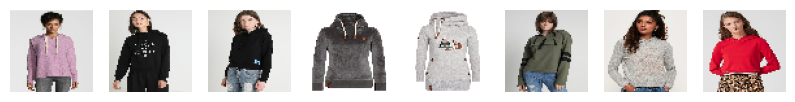


In [38]:
def display_images(imagesPath):
  listOfImages = getListOfImages(imagesPath) #Naima: get the list of images
  listOfImagesTemp = listOfImages.copy()
  random.shuffle(listOfImagesTemp) # Naima: use matplotlib to display 3 random images
  fig, axes = plt.subplots(1,8, figsize=(10, 10))
  axes.ravel()
  for i in range(8):
    image = cv2.imread(listOfImagesTemp[i])
    imageRgb = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    imageRgbResized = cv2.resize(imageRgb, (64, 64), interpolation=cv2.INTER_NEAREST) #Naima: resize images to 64x64x3 (the DCGAN output)
    axes[i].axis('off')
    axes[i].imshow(imageRgbResized)

This function will display a number of fake images (e.i, generated by the DCGAN).

`images: is the list of fake images`

`n_cols: is the number of fake images to be displayed`
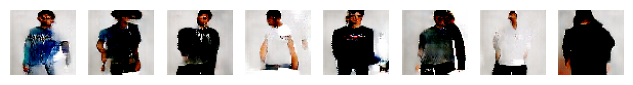

In [39]:
def Display_fake_images(images, n_cols=None):
    display.clear_output(wait=False)
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(10,10))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image)
        plt.axis('off')

This function will build the generator of the DCGAN as follow:

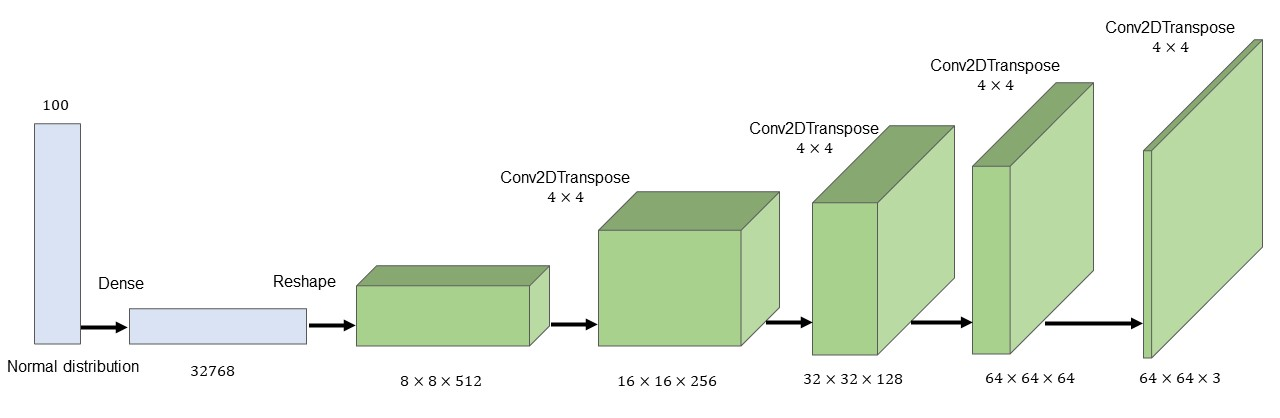

`randomNormalDimensions: is the dimension of the normal distrubition, that will be feed into the generator`



In [40]:
def build_generator(randomNormalDimensions):
  generator = keras.models.Sequential([
    tf.keras.layers.Dense(8*8*512, activation='selu', input_shape=[randomNormalDimensions], name='generator_dense'),
    tf.keras.layers.Reshape((8, 8, 512), name='generator_reshape'),
    tf.keras.layers.BatchNormalization(name = 'generator_batch_normalization'),
    tf.keras.layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding='SAME', activation='selu', name='generator_conv2dTranspose_1'),
    tf.keras.layers.BatchNormalization(name = 'generator_batch_normalization_2'),
    tf.keras.layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding='SAME', activation='selu', name='generator_conv2dTranspose_2'),
    tf.keras.layers.BatchNormalization(name = 'generator_batch_normalization_3'),
    tf.keras.layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding='SAME', activation='selu', name='generator_conv2dTranspose_3'),
    tf.keras.layers.BatchNormalization(name = 'generator_batch_normalization_4'),
    tf.keras.layers.Conv2DTranspose(3, kernel_size=4, strides=1, padding='SAME', activation='tanh', name='generator_conv2dTranspose_4'),
    ])
  return generator

This function will build the discriminator of the DCGAN as follow: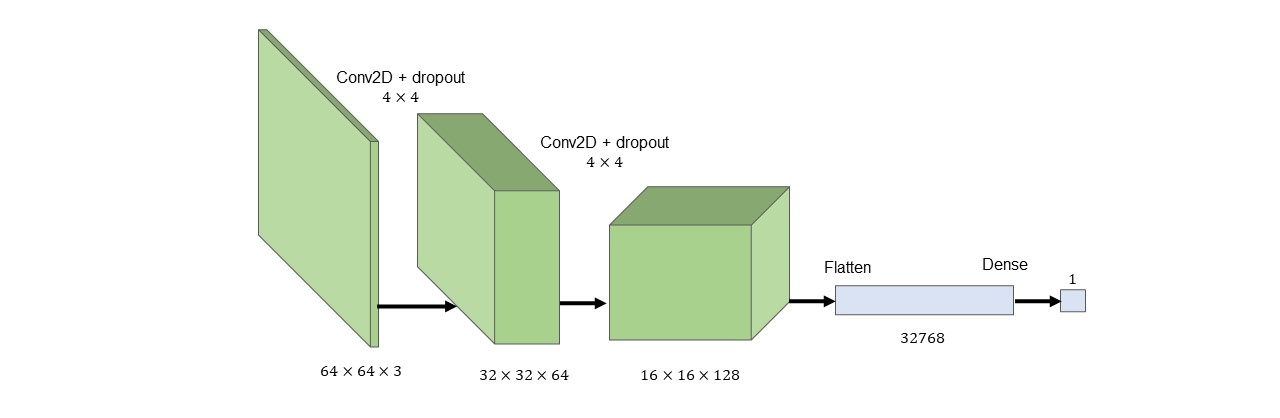

In [41]:
def build_discriminator():
    discriminator = keras.models.Sequential([
      tf.keras.layers.Conv2D(64, kernel_size=4, strides=2, padding='SAME', input_shape = (64,64,3), name='discriminator_conv2d'),
      tf.keras.layers.LeakyReLU(alpha = 0.2, name='discriminator_leakyRelu'),
      tf.keras.layers.Dropout(0.4, name='discriminator_droupout'),
      tf.keras.layers.Conv2D(128, kernel_size=4, strides=2, padding='SAME', input_shape = (64,64,3), name='discriminator_conv2d_1'),
      tf.keras.layers.LeakyReLU(alpha = 0.2, name='discriminator_leakyRelu_1'),
      tf.keras.layers.Dropout(0.4, name='discriminator_droupout_1'),
      tf.keras.layers.Flatten(name='discriminator_flatten'),
      tf.keras.layers.Dense(1, activation = 'sigmoid', name='discriminator_dense')
    ])
    return discriminator

This function will train the DCGAN.


`dcgan: is the DCGAN model`


`randomNormalDimensions: is the dimension of the normal distrubition, that will be feed into the generator`

`n_epochs: is the number of learning epochs`



In [42]:
def train_dcgan(dcgan, dataset, randomNormalDimensions, n_epochs=50):
    generator, discriminator = dcgan.layers
    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs))
        for realImages in dataset:

            #Naima: 1st phase!
            #train discriminator to destiguish between fake and real images
            real_batch_size = realImages.shape[0]
            noise = tf.random.normal([real_batch_size, randomNormalDimensions])
            fakeImages = generator(noise)
            mixed_images = tf.concat([fakeImages, realImages], axis = 0)
            discriminatorLabels = tf.constant([[0.0]]*real_batch_size +
                                    [[1.0]] * real_batch_size)
            discriminator.trainable = True
            discriminatorLabels += 0.05 * tf.random.uniform(tf.shape(discriminatorLabels)) #Naima: use label smoothing to weaken the discriminator
            discriminator.train_on_batch(mixed_images, discriminatorLabels)
            #Naima: 2nd phase!
            #train generator to fool the discriminator
            noise = tf.random.normal([real_batch_size, randomNormalDimensions])
            generatorLabels = tf.constant([1.0]*real_batch_size)
            discriminator.trainable = False
            dcgan.train_on_batch(noise, generatorLabels)
        Display_fake_images(fakeImages, 8)
        plt.show()
    return fakeImages

# Download the Clothing & Models dataset

Fisrt we will download the [Clothing & Models](https://www.kaggle.com/datasets/dqmonn/zalando-store-crawl) data set from kaggle. This latter is a collection of 16k clothing pieces, scraped from the online store Zalando.com.

P.S: Please refer to this [discusion](https://www.kaggle.com/discussions/general/74235) for more datails on how to download and use kaggle data sets within Google Colab.

In [9]:
!pip install -q kaggle

In [12]:
if not os.path.exists('/root/.kaggle/') :  #Naima: you will need to upload the kaggle.json to your google colab workspace before running this cell!
  !mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

In [13]:
!kaggle datasets download -d dqmonn/zalando-store-crawl

100% 2.24G/2.24G [00:23<00:00, 159MB/s]
100% 2.24G/2.24G [00:23<00:00, 103MB/s]


In [15]:
!unzip zalando-store-crawl.zip -d zalando

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: zalando/zalando/zalando/sweatshirt-female/NAA21J00K-K11@8.jpg  
  inflating: zalando/zalando/zalando/sweatshirt-female/NAA21J00L-C11@8.jpg  
  inflating: zalando/zalando/zalando/sweatshirt-female/NAA21J00L-H11@7.1.jpg  
  inflating: zalando/zalando/zalando/sweatshirt-female/NAA21J00L-Q11@8.jpg  
  inflating: zalando/zalando/zalando/sweatshirt-female/NAA21J00M-G11@13.jpg  
  inflating: zalando/zalando/zalando/sweatshirt-female/NAA21J00N-C11@10.jpg  
  inflating: zalando/zalando/zalando/sweatshirt-female/NAA21J00O-Q11@9.jpg  
  inflating: zalando/zalando/zalando/sweatshirt-female/NAA21J00P-N11@5.1.jpg  
  inflating: zalando/zalando/zalando/sweatshirt-female/NAA21J00Q-Q11@10.jpg  
  inflating: zalando/zalando/zalando/sweatshirt-female/NAA21J00U-A11@4.jpg  
  inflating: zalando/zalando/zalando/sweatshirt-female/NAA21J00V-P11@4.jpg  
  inflating: zalando/zalando/zalando/sweatshirt-female/NE221J007-Q11

# Train the DCGAN
Now it's time to train the DCGAN to generate fake images of clothes & models.

First you will need to create the training data set using the Clothes & models data set and display some random examples.

For the sake of computational complexity, we will train the DCGAN to generate images of size 64x64.

In [16]:
train_images = tf.keras.utils.image_dataset_from_directory(
   "/content/zalando/zalando", label_mode=None, image_size=(64, 64), batch_size=32)

Found 32360 files belonging to 1 classes.


In [17]:
train_images = train_images.map(lambda x: (x - 127.5) / 127.5) #Naima: normalize the images pixels between [-1, 1]

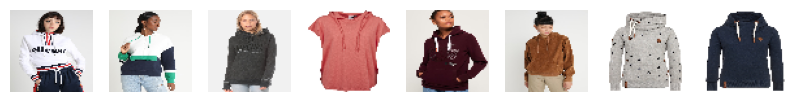

In [43]:
display_images("/content/zalando/zalando/hoodies-female/")

In [44]:
randomNormalDimensions = 100

In [45]:
generator = build_generator(randomNormalDimensions)
discriminator = build_discriminator()
discriminator.compile(loss='bce', optimizer='sgd') #Naima: use SGD for the discriminator
discriminator.trainable = False
dcgan = keras.models.Sequential([generator, discriminator])
dcgan.compile(loss='bce', optimizer='adam') #Naima: use ADAM for the generator

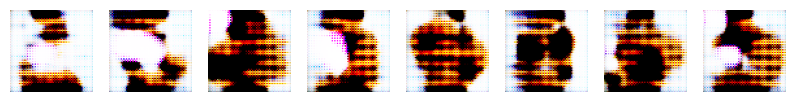

Epoch 2/50


KeyboardInterrupt: ignored

In [46]:
epochs = 50
fake_images = train_dcgan(dcgan, train_images, randomNormalDimensions, epochs)

In [ ]:
Display_fake_images(fake_images, 16)
plt.show()